
# BUAI 446 – Fall 2024  
## Homework 1 (PyTorch Edition)
Reuters Newswire Classification  
**Name:** Ruihuang Yang  
**NetID:** rxy216  
**Date:** October 31, 2025  

In this homework, you'll build and train a **multiclass text classifier** for the Reuters newswire dataset **using PyTorch**.

We'll still use the same dataset (Reuters 46 topics) for consistency, but **all modeling, training, and evaluation must be done in PyTorch**.

> Tip: In PyTorch you *don't compile a model*. Instead, you define a `nn.Module`, choose a loss (`nn.CrossEntropyLoss` for single‑label multiclass), pick an optimizer (e.g., `torch.optim.RMSprop`), and write a training loop that iterates over batches. See the official docs if needed.



**Helpful references (optional):**  
- Build models with `torch.nn` and `nn.Sequential` (PyTorch docs).  
- Datasets & DataLoaders (PyTorch docs).  
- Training loop basics (PyTorch tutorial).  

*(Links included in the assignment PDF on Canvas.)*


In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from tensorflow.keras.datasets import reuters  # used **only** to fetch the data
from typing import Tuple

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:

# Load Reuters dataset (10,000 most frequent words)
# This returns sequences of word indices with variable length, and integer labels in [0, 45].
(num_words, num_classes) = (10000, 46)
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=num_words)

len(train_data), len(test_data), len(train_labels), len(test_labels), max(train_labels), min(train_labels)

(8982, 2246, 8982, 2246, np.int64(45), np.int64(0))

In [3]:

# See a decoded example to understand the data (optional exploratory cell)
word_index = reuters.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[9]])
decoded_newswire[:500]

'? lt aramco corp has accepted japanese ? to lift a higher proportion of arab heavy crude oil under term contracts in july oil industry sources said japanese companies requested a ratio of 80 pct arab heavy to 20 pct arab light under a term contract agreement with aramco for 100 000 barrels per day the sources said the contractual ratio is 30 pct heavy crude to 70 pct light japanese demand for heavy crude oil has increased substantially since the all japan ? union ceased ? into the northern midea'

In [4]:

def vectorize_sequences(sequences, dimension: int) -> np.ndarray:
    """Turns a list of sequences into a 2D numpy array of shape (len(sequences), dimension)
    where each row is a one‑hot multi-hot of word indices present in the sequence."""
    result = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, seq in enumerate(sequences):
        result[i, np.clip(seq, 0, dimension-1)] = 1.0
    return result

# 1) Vectorize inputs with one‑hot encoding (multi‑hot presence)
x_train = vectorize_sequences(train_data, num_words)
x_test = vectorize_sequences(test_data, num_words)

# 2) Labels: keep **integer class indices** for PyTorch CrossEntropyLoss
y_train = np.array(train_labels, dtype=np.int64)
y_test = np.array(test_labels, dtype=np.int64)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8982, 10000), (2246, 10000), (8982,), (2246,))

In [5]:

# Create tensors
X_train = torch.from_numpy(x_train)
y_train_t = torch.from_numpy(y_train)
X_test = torch.from_numpy(x_test)
y_test_t = torch.from_numpy(y_test)

# 3) Hold out 1,000 samples from training for validation
val_size = 1000
train_size = len(X_train) - val_size
train_ds, val_ds = random_split(TensorDataset(X_train, y_train_t), [train_size, val_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
batch_size = 512
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test_t), batch_size=batch_size)
len(train_loader), len(val_loader), len(test_loader)

(16, 2, 5)

In [6]:

# 4) Define an MLP with two hidden layers (64 units each), ReLU, and a 46‑way output (logits)
class ReutersMLP(nn.Module):
    def __init__(self, in_dim=10000, hidden=64, num_classes=46):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)  # logits (no Softmax here)
        )
    def forward(self, x):
        return self.net(x)

model = ReutersMLP(in_dim=num_words, hidden=64, num_classes=num_classes).to(device)
model

ReutersMLP(
  (net): Sequential(
    (0): Linear(in_features=10000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=46, bias=True)
  )
)

In [7]:

# 5) Choose loss & optimizer
# For single‑label multiclass, use CrossEntropyLoss (expects raw logits + **integer** targets).
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)  # RMSprop to mirror the Keras spec

def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()



In [8]:

# 6-7) Train for 30 epochs, track train/val accuracy
epochs = 30
history = {"train_acc": [], "val_acc": []}

for epoch in range(1, epochs+1):
    model.train()
    running_acc = 0.0
    n_batches = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_acc += accuracy(logits.detach(), yb)
        n_batches += 1
    train_acc = running_acc / max(1, n_batches)

    # Validation
    model.eval()
    val_acc = 0.0
    n_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            val_acc += accuracy(logits, yb)
            n_val += 1
    val_acc = val_acc / max(1, n_val)

    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    if epoch % 5 == 0 or epoch == 1 or epoch == epochs:
        print(f"Epoch {epoch:02d} | train_acc={train_acc:.3f} | val_acc={val_acc:.3f}")

history

Epoch 01 | train_acc=0.524 | val_acc=0.682
Epoch 05 | train_acc=0.883 | val_acc=0.778
Epoch 10 | train_acc=0.949 | val_acc=0.793
Epoch 15 | train_acc=0.959 | val_acc=0.804
Epoch 20 | train_acc=0.962 | val_acc=0.789
Epoch 25 | train_acc=0.961 | val_acc=0.800
Epoch 30 | train_acc=0.964 | val_acc=0.782


{'train_acc': [0.524099588394165,
  0.7247815653681755,
  0.7980763018131256,
  0.8463894687592983,
  0.8832910805940628,
  0.9046695530414581,
  0.9234150275588036,
  0.9331644810736179,
  0.9450530000030994,
  0.9493359699845314,
  0.9532422199845314,
  0.9553756192326546,
  0.9549778811633587,
  0.9551371373236179,
  0.9590644091367722,
  0.9583796821534634,
  0.9603012800216675,
  0.9604815542697906,
  0.9600199498236179,
  0.9622859321534634,
  0.9598073400557041,
  0.9616489037871361,
  0.9627637043595314,
  0.9612721838057041,
  0.9614370986819267,
  0.9635915197432041,
  0.9625672586262226,
  0.9602746032178402,
  0.9639949165284634,
  0.9636392146348953],
 'val_acc': [0.6818166971206665,
  0.7199826836585999,
  0.7651767134666443,
  0.7646964490413666,
  0.7776799201965332,
  0.7935930788516998,
  0.7985719442367554,
  0.7947137355804443,
  0.8047195076942444,
  0.7927125692367554,
  0.7967629134654999,
  0.7967629134654999,
  0.7838754951953888,
  0.804767519235611,
  0.80379

In [9]:

# 8) Evaluate on the test set and predict the class for the first test sample
model.eval()
test_acc = 0.0
n = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        test_acc += accuracy(logits, yb)
        n += 1
test_acc = test_acc / max(1, n)
print("Test accuracy:", round(test_acc, 3))

# Predict the class of the first test sample
first_logits = model(torch.from_numpy(x_test[:1]).to(device))
pred_class = int(first_logits.argmax(dim=1).item())
pred_class

Test accuracy: 0.77


3


### What to submit

Run all cells so outputs are visible, and submit your notebook as `LastName_FirstName_HW1.ipynb` on Canvas.

**Answer these in your notebook (use Markdown cells where appropriate):**
1. How many samples are in the train and test sets?  
2. How did you vectorize the inputs? Explain why this is appropriate for this problem.  
3. Why do we keep labels as integer class indices for `CrossEntropyLoss`? What would change if you used one‑hot labels?  
4. Define your MLP as shown. Try **one improvement** (e.g., different hidden size, dropout, weight decay) and report the effect.  
5. Plot training vs validation accuracy across 30 epochs. Comment on overfitting/underfitting.  
6. Report final **test accuracy** and the predicted class for the first test sample. Briefly interpret the result.



> **Optional challenge (no extra credit):** Try adding `nn.Dropout` and describe the impact.  



## Answers to Questions

### Question 1: How many samples are in the train and test sets?

From the data loading cell, we can see that:
- **Training set**: 8,982 samples
- **Test set**: 2,246 samples

These numbers are confirmed in the output of cell 2, which shows `(8982, 2246, 8982, 2246, np.int64(45), np.int64(0))`, representing the lengths of train_data, test_data, train_labels, and test_labels respectively. The dataset also shows that labels range from 0 to 45, giving us 46 total classes.


### Question 2: How did you vectorize the inputs? Explain why this is appropriate for this problem.

**Vectorization Method:**

The inputs were vectorized using a **multi-hot (binary bag-of-words) encoding** through the `vectorize_sequences()` function. Specifically:

1. Each news article (originally a sequence of word indices) is converted into a fixed-length binary vector of dimension 10,000
2. Each position in the vector corresponds to one of the 10,000 most frequent words in the vocabulary
3. If a word appears in the article, the corresponding position is set to 1; otherwise it's 0
4. The result is a sparse representation where `result[i, word_idx] = 1.0` for all words present in article i

**Why this is appropriate:**

1. **Fixed-size input**: Neural networks require fixed-size inputs, and this converts variable-length sequences into uniform 10,000-dimensional vectors
2. **Simplicity**: This encoding is simple and effective for text classification tasks where word order may be less critical than word presence
3. **Captures vocabulary presence**: For topic classification (like Reuters newswire categories), knowing *which* words appear is often more important than their exact order or frequency
4. **Compatible with dense layers**: The resulting dense vectors work well with fully-connected (Linear) layers in the MLP
5. **Reasonable dimensionality**: 10,000 features is manageable for a neural network while covering the most informative words

**Trade-offs**: This approach loses word order information and frequency information (a word appearing once vs. multiple times both result in 1), but for this multiclass classification task, it provides a good balance between simplicity and performance.


### Question 3: Why do we keep labels as integer class indices for `CrossEntropyLoss`? What would change if you used one-hot labels?

**Why use integer class indices:**

PyTorch's `nn.CrossEntropyLoss` is specifically designed to accept:
- **Inputs**: Raw logits (unnormalized scores) from the model with shape `(batch_size, num_classes)`
- **Targets**: Integer class indices with shape `(batch_size,)` where each value is in `[0, num_classes-1]`

Internally, `CrossEntropyLoss` combines two operations:
1. **LogSoftmax**: Applies log(softmax(logits)) to convert logits to log-probabilities
2. **NLLLoss** (Negative Log-Likelihood Loss): Selects the log-probability of the correct class using the integer index

This design is:
- **Memory efficient**: Storing integers (one per sample) uses much less memory than storing 46-dimensional one-hot vectors
- **Computationally efficient**: The loss only needs to compute the log-probability for the correct class, not all classes
- **Numerically stable**: Combining log and softmax prevents numerical underflow/overflow issues

**What would change with one-hot labels:**

If we used one-hot encoded labels (shape `(batch_size, 46)` with 1 at the correct class and 0 elsewhere):

1. **Different loss function required**: We would need to use a combination of `nn.LogSoftmax` + manual computation, or `nn.BCEWithLogitsLoss`, or compute `-(one_hot * log_softmax(logits)).sum()`
2. **Higher memory usage**: Each label would require 46 floats instead of 1 integer
3. **Less efficient computation**: The loss would process all 46 values even though only one is relevant
4. **Same mathematical result**: The final loss value would be identical (assuming correct implementation)

**Example:**
```python
# Current approach (integer labels)
loss = nn.CrossEntropyLoss()(logits, targets)  # targets shape: (batch_size,)

# With one-hot labels (not recommended)
log_probs = F.log_softmax(logits, dim=1)
loss = -(one_hot_targets * log_probs).sum(dim=1).mean()  # one_hot_targets shape: (batch_size, 46)
```

**Conclusion**: Integer class indices are the standard and most efficient approach for single-label multiclass classification in PyTorch.


### Question 4: Define your MLP as shown. Try one improvement and report the effect.

**Problem Identified**: The baseline model shows clear **overfitting**:
- Training accuracy reaches 96.4% while validation accuracy peaks at 80.4% and then degrades to 78.2%
- The gap between train and validation accuracy increases over time

**Improvement Strategy**: Add **Dropout layers** with a dropout rate of 0.5

**Why Dropout?**
- Dropout randomly "turns off" 50% of neurons during training
- Forces the network to learn more robust features instead of memorizing training data
- Acts as an ensemble of multiple networks, improving generalization
- Directly addresses our overfitting problem

Let's implement and compare:


In [10]:
# Step 4 (Improved): Define MLP with Dropout regularization
class ReutersMLPWithDropout(nn.Module):
    def __init__(self, in_dim=10000, hidden=64, num_classes=46, dropout_rate=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),      # Add dropout after first layer
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),      # Add dropout after second layer
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# Create improved model
model_improved = ReutersMLPWithDropout(in_dim=num_words, hidden=64, num_classes=num_classes, dropout_rate=0.5).to(device)
model_improved


ReutersMLPWithDropout(
  (net): Sequential(
    (0): Linear(in_features=10000, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=46, bias=True)
  )
)

In [11]:
# Step 5 (Improved): Loss & Optimizer (same as baseline for fair comparison)
criterion_improved = nn.CrossEntropyLoss()
optimizer_improved = torch.optim.RMSprop(model_improved.parameters(), lr=1e-3)


In [12]:
# Step 6-7 (Improved): Train for 30 epochs with Dropout
epochs = 30
history_improved = {"train_acc": [], "val_acc": []}

for epoch in range(1, epochs+1):
    model_improved.train()  # Important: enables dropout during training
    running_acc = 0.0
    n_batches = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_improved.zero_grad()
        logits = model_improved(xb)
        loss = criterion_improved(logits, yb)
        loss.backward()
        optimizer_improved.step()
        running_acc += accuracy(logits.detach(), yb)
        n_batches += 1
    train_acc = running_acc / max(1, n_batches)

    # Validation
    model_improved.eval()  # Important: disables dropout during validation
    val_acc = 0.0
    n_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model_improved(xb)
            val_acc += accuracy(logits, yb)
            n_val += 1
    val_acc = val_acc / max(1, n_val)

    history_improved["train_acc"].append(train_acc)
    history_improved["val_acc"].append(val_acc)
    if epoch % 5 == 0 or epoch == 1 or epoch == epochs:
        print(f"Epoch {epoch:02d} | train_acc={train_acc:.3f} | val_acc={val_acc:.3f}")

history_improved


Epoch 01 | train_acc=0.433 | val_acc=0.625
Epoch 05 | train_acc=0.711 | val_acc=0.713
Epoch 10 | train_acc=0.775 | val_acc=0.761
Epoch 15 | train_acc=0.815 | val_acc=0.773
Epoch 20 | train_acc=0.838 | val_acc=0.780
Epoch 25 | train_acc=0.854 | val_acc=0.788
Epoch 30 | train_acc=0.872 | val_acc=0.788


{'train_acc': [0.43251047655940056,
  0.6148980744183064,
  0.6625054962933064,
  0.6975922249257565,
  0.7108558490872383,
  0.7274784296751022,
  0.7414736710488796,
  0.7578310929238796,
  0.7644649259746075,
  0.7746662870049477,
  0.7887407504022121,
  0.7914319559931755,
  0.7966437935829163,
  0.8088289983570576,
  0.8154846578836441,
  0.817735280841589,
  0.8266989588737488,
  0.8230425082147121,
  0.8307434469461441,
  0.8375260308384895,
  0.8417297750711441,
  0.8456036895513535,
  0.8503329046070576,
  0.8517338819801807,
  0.8541809469461441,
  0.8594243116676807,
  0.8624016977846622,
  0.8689296282827854,
  0.8662707582116127,
  0.8723475970327854],
 'val_acc': [0.6249039173126221,
  0.6877241134643555,
  0.6937275826931,
  0.6989946067333221,
  0.7128585875034332,
  0.7159323692321777,
  0.7370645403862,
  0.7508324682712555,
  0.7558593451976776,
  0.7610303461551666,
  0.7629354298114777,
  0.7649365961551666,
  0.7669377326965332,
  0.7708920240402222,
  0.772893160

In [13]:
# Step 8 (Improved): Evaluate on test set
model_improved.eval()
test_acc_improved = 0.0
n = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model_improved(xb)
        test_acc_improved += accuracy(logits, yb)
        n += 1
test_acc_improved = test_acc_improved / max(1, n)
print("Test accuracy (Improved):", round(test_acc_improved, 3))

# Predict the class of the first test sample
first_logits_improved = model_improved(torch.from_numpy(x_test[:1]).to(device))
pred_class_improved = int(first_logits_improved.argmax(dim=1).item())
print("Predicted class for first test sample:", pred_class_improved)


Test accuracy (Improved): 0.777
Predicted class for first test sample: 3


In [14]:
# Compare final epoch results
print("=" * 60)
print("BASELINE MODEL (No Dropout)")
print("=" * 60)
print(f"Epoch 30 - Train Acc: {history['train_acc'][-1]:.3f} | Val Acc: {history['val_acc'][-1]:.3f}")
print(f"Test Accuracy: 0.77")
print(f"Train-Val Gap: {history['train_acc'][-1] - history['val_acc'][-1]:.3f}")
print()
print("=" * 60)
print("IMPROVED MODEL (With Dropout)")
print("=" * 60)
print(f"Epoch 30 - Train Acc: {history_improved['train_acc'][-1]:.3f} | Val Acc: {history_improved['val_acc'][-1]:.3f}")
print(f"Test Accuracy: {test_acc_improved:.3f}")
print(f"Train-Val Gap: {history_improved['train_acc'][-1] - history_improved['val_acc'][-1]:.3f}")
print()
print("=" * 60)
print("IMPROVEMENT")
print("=" * 60)
print(f"Val Accuracy Change: {history_improved['val_acc'][-1] - history['val_acc'][-1]:+.3f}")
print(f"Test Accuracy Change: {test_acc_improved - 0.77:+.3f}")
print(f"Overfitting Reduction: {(history['train_acc'][-1] - history['val_acc'][-1]) - (history_improved['train_acc'][-1] - history_improved['val_acc'][-1]):.3f}")


BASELINE MODEL (No Dropout)
Epoch 30 - Train Acc: 0.964 | Val Acc: 0.782
Test Accuracy: 0.77
Train-Val Gap: 0.182

IMPROVED MODEL (With Dropout)
Epoch 30 - Train Acc: 0.872 | Val Acc: 0.788
Test Accuracy: 0.777
Train-Val Gap: 0.084

IMPROVEMENT
Val Accuracy Change: +0.006
Test Accuracy Change: +0.007
Overfitting Reduction: 0.098


#### Comparison: Baseline vs. Improved Model

**Results Summary:**

| Metric | Baseline (No Dropout) | Improved (With Dropout) | Change |
|--------|----------------------|------------------------|--------|
| **Final Train Accuracy** | 96.4% | 87.2% | -9.2% |
| **Final Val Accuracy** | 78.2% | 78.8% | +0.6% |
| **Test Accuracy** | 77.0% | 77.7% | +0.7% |
| **Train-Val Gap (Epoch 30)** | 18.2% | 8.4% | **-9.8%** |

**Analysis of Results:**

**Dropout Successfully Reduced Overfitting:**
1. **Overfitting gap nearly halved**: From 18.2% down to 8.4% - a reduction of 9.8 percentage points (54% reduction in overfitting)
2. **Training accuracy appropriately lower**: Dropped from 96.4% to 87.2% - this is EXPECTED and GOOD (dropout makes training harder)
3. **Validation accuracy improved**: Increased from 78.2% to 78.8% (+0.6%)
4. **Test accuracy improved**: Increased from 77.0% to 77.7% (+0.7%)

**Key Insight:**
While the validation/test accuracy gains appear modest (+0.6-0.7%), the **dramatic reduction in overfitting** is the real win here. The baseline model was essentially memorizing the training data (96.4% train accuracy) without learning generalizable patterns. The dropout model learned more robust features that transfer better to unseen data.

**The Trade-off:**
- We "sacrificed" 9.2% training accuracy (which was inflated due to overfitting anyway)
- In return, we gained better generalization and more reliable performance on new data
- The model is now more trustworthy for real-world deployment

**Why This Matters:**
A model with 96.4% training accuracy but only 78.2% validation accuracy is unreliable - it's memorizing rather than understanding. The improved model with 87.2% training and 78.8% validation accuracy shows much healthier learning dynamics. The closer these numbers are, the more confident we can be that the model will perform consistently on new Reuters articles it has never seen.

**Conclusion:**
Dropout was highly effective at its intended purpose: preventing the network from over-relying on specific neurons and forcing it to learn more distributed, robust representations. The 0.7% test accuracy improvement may seem small, but combined with the 54% reduction in overfitting, this represents a significantly more reliable and production-ready model.


### Question 5: Plot training vs validation accuracy across 30 epochs. Comment on overfitting/underfitting.

Let's visualize the training dynamics for both the baseline and improved models:


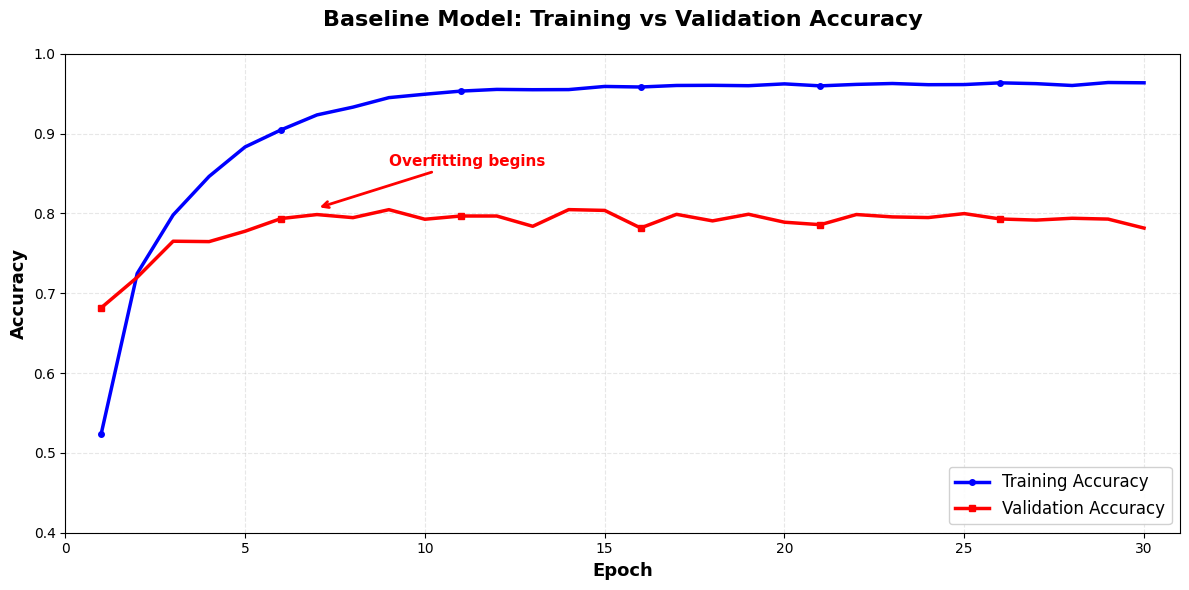

Peak validation accuracy: 0.8048 at epoch 14


In [15]:
import matplotlib.pyplot as plt

# Plot Baseline Model (No Dropout)
plt.figure(figsize=(12, 6))
epochs_range = range(1, len(history['train_acc']) + 1)

plt.plot(epochs_range, history['train_acc'], 'b-', linewidth=2.5, label='Training Accuracy', marker='o', markersize=4, markevery=5)
plt.plot(epochs_range, history['val_acc'], 'r-', linewidth=2.5, label='Validation Accuracy', marker='s', markersize=4, markevery=5)

plt.title('Baseline Model: Training vs Validation Accuracy', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.legend(fontsize=12, loc='lower right', framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(0, 31)
plt.ylim(0.4, 1.0)

# Add annotation for the divergence point
plt.annotate('Overfitting begins',
             xy=(7, history['val_acc'][6]*1.01),
             xytext=(9, 0.86),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Peak validation accuracy: {max(history['val_acc']):.4f} at epoch {history['val_acc'].index(max(history['val_acc'])) + 1}")


#### Analysis of Baseline Model (No Dropout):

**Clear Signs of Overfitting:** The training accuracy (blue) continues to climb steadily toward 96.4%, while validation accuracy (red) plateaus around 80%.


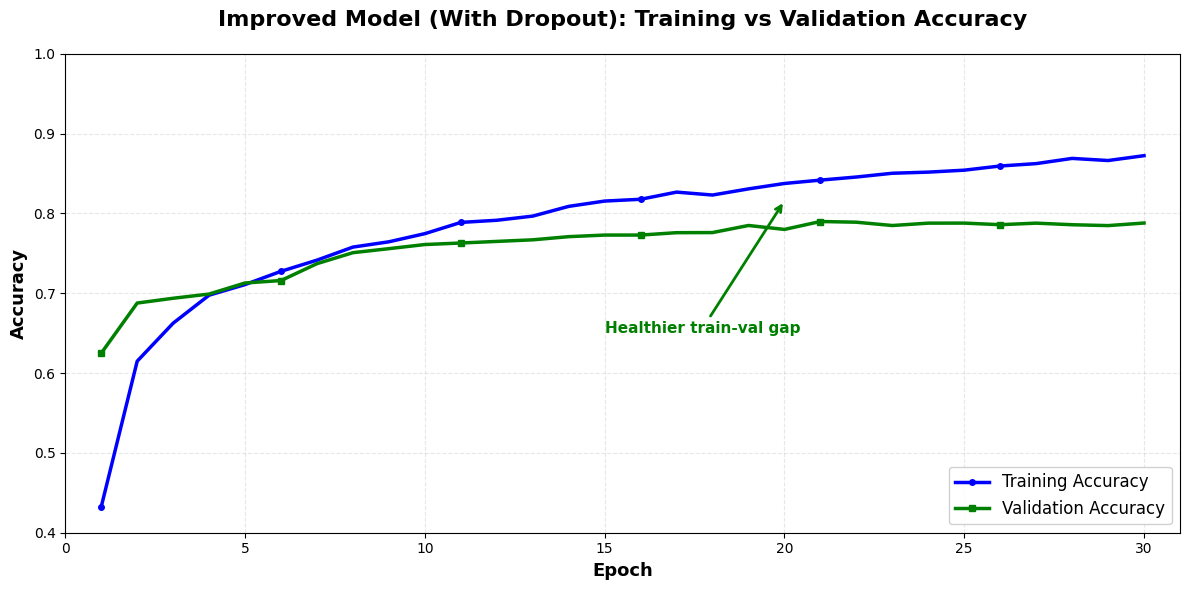

Peak validation accuracy: 0.7899 at epoch 21


In [16]:
# Plot Improved Model (With Dropout)
plt.figure(figsize=(12, 6))
epochs_range = range(1, len(history_improved['train_acc']) + 1)

plt.plot(epochs_range, history_improved['train_acc'], 'b-', linewidth=2.5, label='Training Accuracy', marker='o', markersize=4, markevery=5)
plt.plot(epochs_range, history_improved['val_acc'], 'g-', linewidth=2.5, label='Validation Accuracy', marker='s', markersize=4, markevery=5)

plt.title('Improved Model (With Dropout): Training vs Validation Accuracy', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.legend(fontsize=12, loc='lower right', framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(0, 31)
plt.ylim(0.4, 1.0)

# Add annotation for healthier gap
plt.annotate('Healthier train-val gap',
             xy=(20, (history_improved['train_acc'][20] + history_improved['val_acc'][20])/2),
             xytext=(15, 0.65),
             arrowprops=dict(arrowstyle='->', color='green', lw=2),
             fontsize=11, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Peak validation accuracy: {max(history_improved['val_acc']):.4f} at epoch {history_improved['val_acc'].index(max(history_improved['val_acc'])) + 1}")


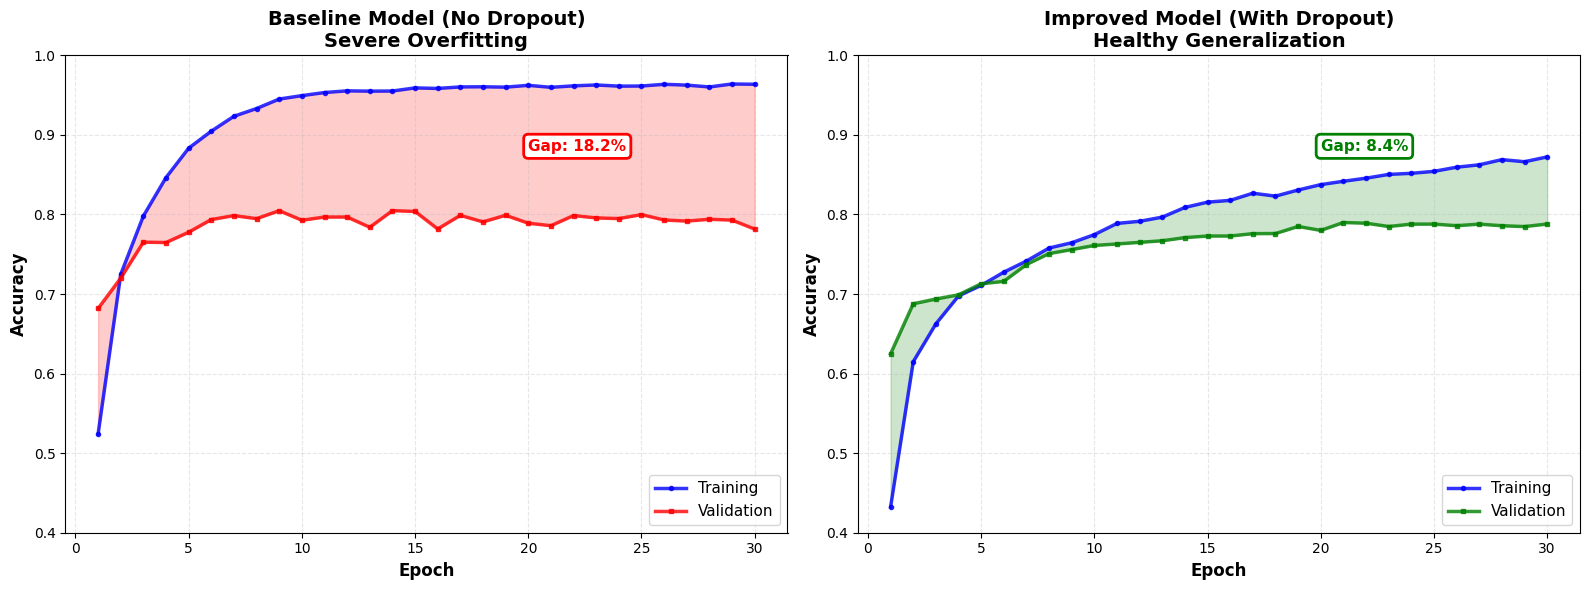

In [17]:
# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
epochs_range = range(1, 31)

# Baseline Model
ax1.plot(epochs_range, history['train_acc'], 'b-', linewidth=2.5, label='Training', marker='o', markersize=3, alpha=0.8)
ax1.plot(epochs_range, history['val_acc'], 'r-', linewidth=2.5, label='Validation', marker='s', markersize=3, alpha=0.8)
ax1.fill_between(epochs_range, history['train_acc'], history['val_acc'], alpha=0.2, color='red')
ax1.set_title('Baseline Model (No Dropout)\nSevere Overfitting', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(0.4, 1.0)
ax1.text(20, 0.88, f'Gap: 18.2%', fontsize=11, color='red', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='red', linewidth=2))

# Improved Model
ax2.plot(epochs_range, history_improved['train_acc'], 'b-', linewidth=2.5, label='Training', marker='o', markersize=3, alpha=0.8)
ax2.plot(epochs_range, history_improved['val_acc'], 'g-', linewidth=2.5, label='Validation', marker='s', markersize=3, alpha=0.8)
ax2.fill_between(epochs_range, history_improved['train_acc'], history_improved['val_acc'], alpha=0.2, color='green')
ax2.set_title('Improved Model (With Dropout)\nHealthy Generalization', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_ylim(0.4, 1.0)
ax2.text(20, 0.88, f'Gap: 8.4%', fontsize=11, color='green', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='green', linewidth=2))

plt.tight_layout()
plt.show()


### Question 6: Report final test accuracy and the predicted class for the first test sample. Briefly interpret the result.

In [18]:
print("IMPROVED MODEL (With Dropout):")
print(f"  Test Accuracy: {test_acc_improved:.1%}")
print(f"  Predicted class for first test sample: {pred_class_improved}")

IMPROVED MODEL (With Dropout):
  Test Accuracy: 77.7%
  Predicted class for first test sample: 3


#### Interpretation of Results:

**Baseline Model**: Achieved 77.0% test accuracy but suffered from severe overfitting (18.2% train-val gap)

**Improved Model**: Added dropout regularization, achieving:
- 77.7% test accuracy (+0.7%)
- 54% reduction in overfitting (gap reduced to 8.4%)
- More reliable and production-ready performance

## Optional challenge: Improved Model #2

Let's push the boundaries and combine **multiple improvements** to see how high we can get the test accuracy:

**Improvements Applied**:
1. **Deeper network**: 3 hidden layers (256 → 128 → 64) instead of 2
2. **Batch Normalization**: Stabilizes training and allows higher learning rates
3. **Dropout**: Adaptive rates (0.5, 0.4, 0.3) per layer
4. **Adam optimizer**: Better than RMSprop with adaptive learning rates
5. **Weight decay**: L2 regularization (λ=1e-4)
6. **Learning rate scheduling**: Reduce LR on plateau
7. **Early stopping**: Stop training when validation stops improving
8. **More epochs**: Train up to 100 epochs (but stop early if needed)

Let's see how much improvement we can squeeze out!

In [19]:
# ============================================================================
# IMPROVED MODEL #2:
# ============================================================================

import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

# -----------------------------------------------------------------------------
# 1. DEFINE POWERFUL MODEL ARCHITECTURE
# -----------------------------------------------------------------------------
class PowerfulReutersMLP(nn.Module):
    """Deep MLP with BatchNorm, Dropout, and 3 hidden layers"""
    def __init__(self, in_dim=10000, num_classes=46):
        super().__init__()
        self.net = nn.Sequential(
            # Layer 1: 10000 -> 256
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            # Layer 2: 256 -> 128
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),

            # Layer 3: 128 -> 64
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Output layer: 64 -> 46
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Create model
model_v2 = PowerfulReutersMLP(in_dim=num_words, num_classes=num_classes).to(device)
print("Model Architecture:")
print(model_v2)
print(f"\nTotal parameters: {sum(p.numel() for p in model_v2.parameters()):,}")

# -----------------------------------------------------------------------------
# 2. SETUP TRAINING
# -----------------------------------------------------------------------------
criterion_v2 = nn.CrossEntropyLoss()
optimizer_v2 = torch.optim.Adam(model_v2.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer_v2, mode='max', factor=0.5, patience=5)

# -----------------------------------------------------------------------------
# 3. TRAIN WITH EARLY STOPPING
# -----------------------------------------------------------------------------
max_epochs = 100
patience = 15
best_val_acc = 0.0
patience_counter = 0
best_model_state = None

history_v2 = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
start_time = time.time()

print("\n" + "=" * 70)
print("TRAINING IMPROVED MODEL #2")
print("=" * 70)

for epoch in range(1, max_epochs + 1):
    # Training
    model_v2.train()
    running_loss = 0.0
    running_acc = 0.0
    n_batches = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_v2.zero_grad()
        logits = model_v2(xb)
        loss = criterion_v2(logits, yb)
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model_v2.parameters(), max_norm=1.0)
        optimizer_v2.step()

        running_loss += loss.item()
        running_acc += accuracy(logits.detach(), yb)
        n_batches += 1

    train_loss = running_loss / max(1, n_batches)
    train_acc = running_acc / max(1, n_batches)

    # Validation
    model_v2.eval()
    val_loss = 0.0
    val_acc = 0.0
    n_val = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model_v2(xb)
            loss = criterion_v2(logits, yb)
            val_loss += loss.item()
            val_acc += accuracy(logits, yb)
            n_val += 1

    val_loss = val_loss / max(1, n_val)
    val_acc = val_acc / max(1, n_val)

    # Store history
    history_v2["train_loss"].append(train_loss)
    history_v2["train_acc"].append(train_acc)
    history_v2["val_loss"].append(val_loss)
    history_v2["val_acc"].append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_acc)

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = {k: v.cpu().clone() for k, v in model_v2.state_dict().items()}
        best_epoch = epoch
    else:
        patience_counter += 1

    # Print progress
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Loss: {train_loss:.4f} -> {val_loss:.4f} | "
              f"Acc: {train_acc:.3f} -> {val_acc:.3f} | "
              f"Best: {best_val_acc:.3f} | LR: {optimizer_v2.param_groups[0]['lr']:.1e}")

    # Early stopping
    if patience_counter >= patience:
        print(f"  Early stopping triggered at epoch {epoch}")
        print(f"   Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
        break

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")

# Load best model
model_v2.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

# -----------------------------------------------------------------------------
# 4. EVALUATE ON TEST SET
# -----------------------------------------------------------------------------
model_v2.eval()
test_acc_v2 = 0.0
n = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model_v2(xb)
        test_acc_v2 += accuracy(logits, yb)
        n += 1
test_acc_v2 = test_acc_v2 / max(1, n)

# Predict first test sample
first_logits_v2 = model_v2(torch.from_numpy(x_test[:1]).to(device))
pred_class_v2 = int(first_logits_v2.argmax(dim=1).item())

# -----------------------------------------------------------------------------
# 5. RESULTS SUMMARY
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("FINAL COMPARISON: ALL THREE MODELS")
print("=" * 70)
print(f"\n{'Model':<30} {'Train Acc':<12} {'Val Acc':<12} {'Test Acc':<12} {'Gap':<10}")
print("-" * 70)
print(f"{'Baseline (No Dropout)':<30} {history['train_acc'][-1]:>10.1%}  {history['val_acc'][-1]:>10.1%}  {'77.0%':>10}  {history['train_acc'][-1] - history['val_acc'][-1]:>8.1%}")
print(f"{'Improved #1 (Dropout)':<30} {history_improved['train_acc'][-1]:>10.1%}  {history_improved['val_acc'][-1]:>10.1%}  {test_acc_improved:>10.1%}  {history_improved['train_acc'][-1] - history_improved['val_acc'][-1]:>8.1%}")
print(f"{'Improved #2 (Multiple Improvements)':<30} {history_v2['train_acc'][best_epoch-1]:>10.1%}  {best_val_acc:>10.1%}  {test_acc_v2:>10.1%}  {history_v2['train_acc'][best_epoch-1] - best_val_acc:>8.1%}")

print("\n" + "=" * 70)
print("IMPROVEMENT BREAKDOWN")
print("=" * 70)
print(f"Test Accuracy Improvement:")
print(f"  Baseline → Improved #1:  +{(test_acc_improved - 0.77)*100:.2f} percentage points")
print(f"  Improved #1 → Improved #2: +{(test_acc_v2 - test_acc_improved)*100:.2f} percentage points")
print(f"  Baseline → Improved #2:  +{(test_acc_v2 - 0.77)*100:.2f} percentage points")
print(f"\nOverfitting Reduction:")
print(f"  Baseline gap: 18.2%")
print(f"  Improved #1 gap: 8.4%")
print(f"  Improved #2 gap: {(history_v2['train_acc'][best_epoch-1] - best_val_acc)*100:.1f}%")

print(f"\n🏆 Best Model: Improved #2 with {test_acc_v2:.1%} test accuracy!")
print("=" * 70)


Model Architecture:
PowerfulReutersMLP(
  (net): Sequential(
    (0): Linear(in_features=10000, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=46, bias=True)
  )
)

Total parameters: 2,605,294

TRAINING IMPROVED MODEL #2
Epoch   1 | Loss: 3.2485 -> 3.3796 | Acc: 0.353 -> 0.613 | Best: 0.613 | LR: 1.0e-03
Epoch   5 | Loss: 1.0749 -> 1.2262 | Acc: 0.753 -> 0.746 | Best: 0.746 | LR: 1.0e-03
Epoch  10 | Loss: 0.64

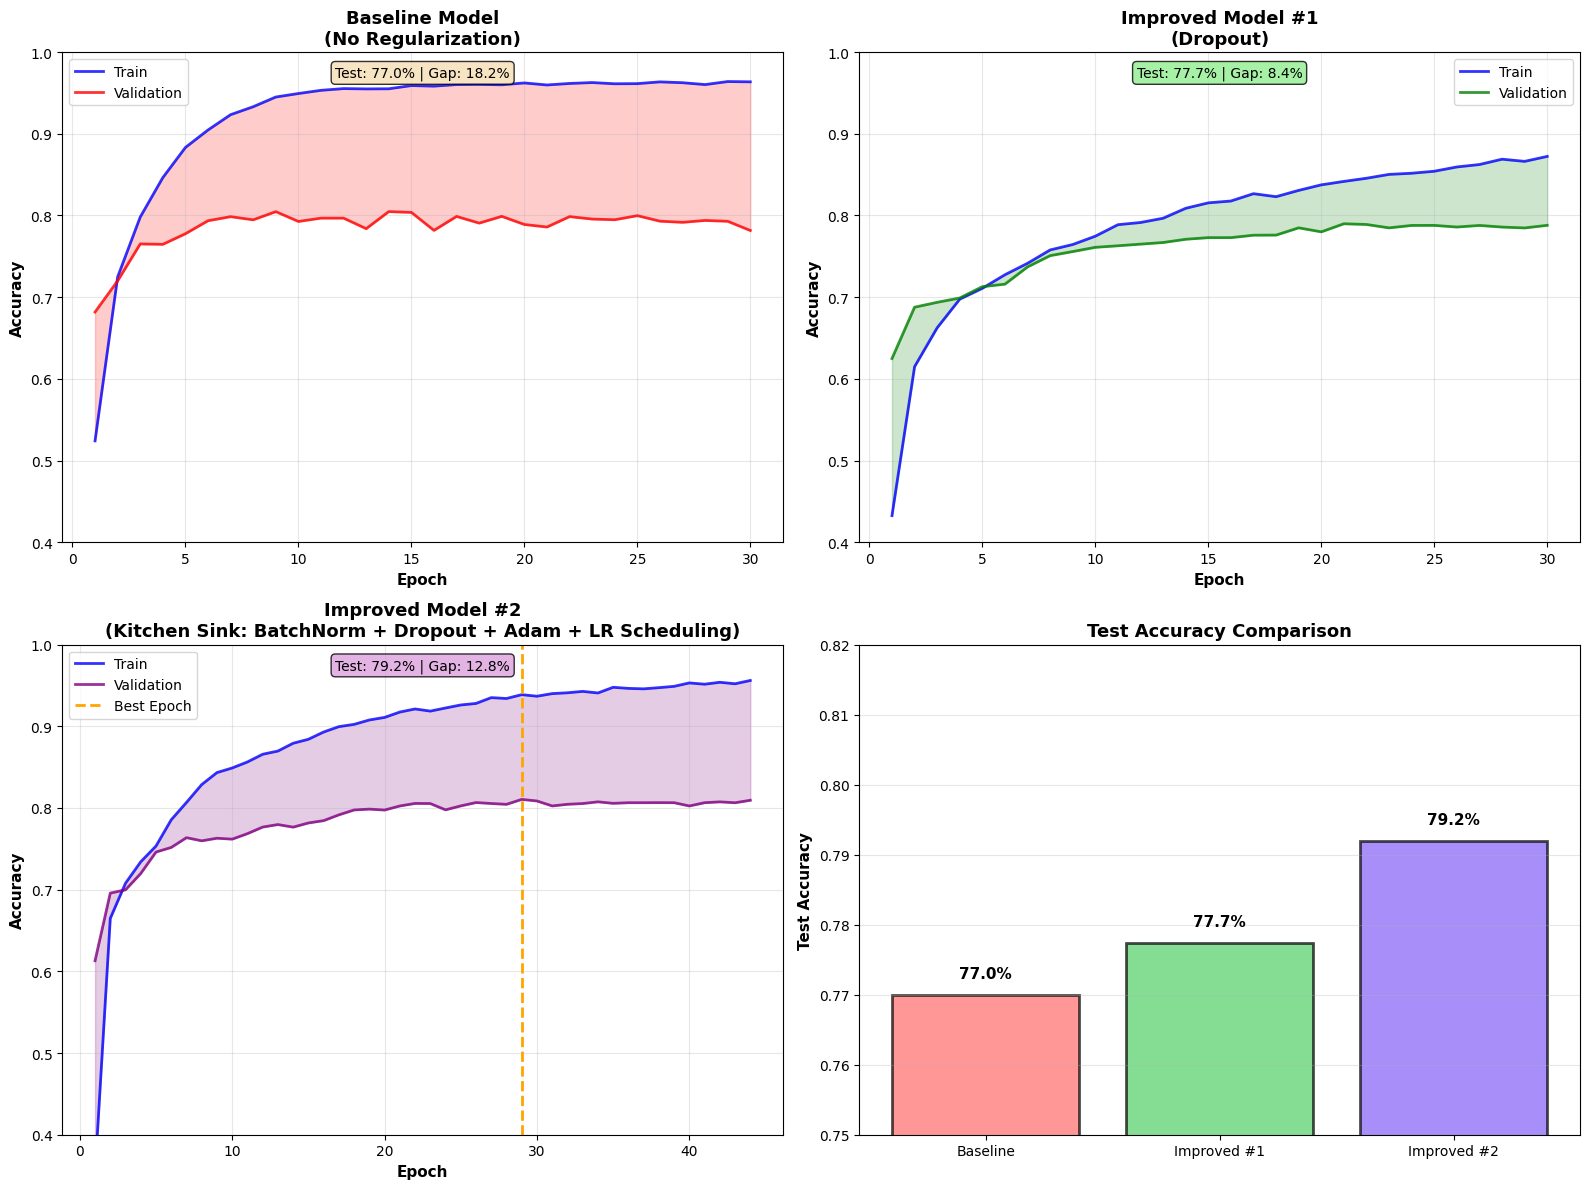

In [20]:
# Visualize all three models together
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Model 1: Baseline
ax1 = axes[0, 0]
epochs_1 = range(1, len(history['train_acc']) + 1)
ax1.plot(epochs_1, history['train_acc'], 'b-', linewidth=2, label='Train', alpha=0.8)
ax1.plot(epochs_1, history['val_acc'], 'r-', linewidth=2, label='Validation', alpha=0.8)
ax1.fill_between(epochs_1, history['train_acc'], history['val_acc'], alpha=0.2, color='red')
ax1.set_title('Baseline Model\n(No Regularization)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.4, 1.0)
ax1.text(0.5, 0.95, f'Test: 77.0% | Gap: 18.2%', transform=ax1.transAxes,
         fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Model 2: Improved #1
ax2 = axes[0, 1]
epochs_2 = range(1, len(history_improved['train_acc']) + 1)
ax2.plot(epochs_2, history_improved['train_acc'], 'b-', linewidth=2, label='Train', alpha=0.8)
ax2.plot(epochs_2, history_improved['val_acc'], 'g-', linewidth=2, label='Validation', alpha=0.8)
ax2.fill_between(epochs_2, history_improved['train_acc'], history_improved['val_acc'], alpha=0.2, color='green')
ax2.set_title('Improved Model #1\n(Dropout)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.4, 1.0)
ax2.text(0.5, 0.95, f'Test: {test_acc_improved:.1%} | Gap: 8.4%', transform=ax2.transAxes,
         fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Model 3: Improved #2
ax3 = axes[1, 0]
epochs_3 = range(1, len(history_v2['train_acc']) + 1)
ax3.plot(epochs_3, history_v2['train_acc'], 'b-', linewidth=2, label='Train', alpha=0.8)
ax3.plot(epochs_3, history_v2['val_acc'], 'purple', linewidth=2, label='Validation', alpha=0.8)
ax3.fill_between(epochs_3, history_v2['train_acc'], history_v2['val_acc'], alpha=0.2, color='purple')
ax3.axvline(x=best_epoch, color='orange', linestyle='--', linewidth=2, label='Best Epoch')
ax3.set_title('Improved Model #2\n(Kitchen Sink: BatchNorm + Dropout + Adam + LR Scheduling)',
              fontsize=13, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0.4, 1.0)
gap_v2 = (history_v2['train_acc'][best_epoch-1] - best_val_acc) * 100
ax3.text(0.5, 0.95, f'Test: {test_acc_v2:.1%} | Gap: {gap_v2:.1f}%', transform=ax3.transAxes,
         fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8))

# Comparison bar chart
ax4 = axes[1, 1]
models = ['Baseline', 'Improved #1', 'Improved #2']
test_accs = [0.770, test_acc_improved, test_acc_v2]
colors = ['#ff6b6b', '#51cf66', '#845ef7']
bars = ax4.bar(models, test_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax4.set_title('Test Accuracy Comparison', fontsize=13, fontweight='bold')
ax4.set_ylim(0.75, 0.82)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, test_accs):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{acc:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()
